In [124]:
!unzip archive.zip

Archive:  archive.zip
replace cats/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [125]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('ai2100-project')
jovian.set_colab_id('1r-hYLeVtkZaqks-JPJ4XMQpKOH5tsla_')

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
project_name = 'ai2100-project'

In [ ]:
DATA_DIR = '../input/cats-faces-64x64-for-generative-models/'

In [ ]:
print(os.listdir('cats')[:10])

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [151]:
train_ds = ImageFolder('cats', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [152]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [153]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [154]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


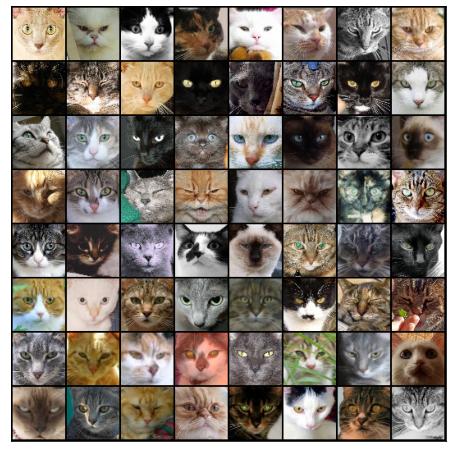

In [155]:
show_batch(train_dl)

In [136]:
!pip install jovian --upgrade --quiet

In [156]:
import jovian

In [157]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/srikaran-p/ai2100-project


'https://jovian.ai/srikaran-p/ai2100-project'

In [184]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [185]:
device = get_default_device()
device

device(type='cuda')

In [186]:
train_dl = DeviceDataLoader(train_dl, device)

In [227]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 32 x 32

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 16 x 16

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 8 x 8

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 4 x 4

    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [228]:
discriminator = to_device(discriminator, device)

In [229]:
latent_size = 128

In [230]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 128, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 4 x 4

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 8 x 8

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 16 x 16

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 16 x 32 x 32

    nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


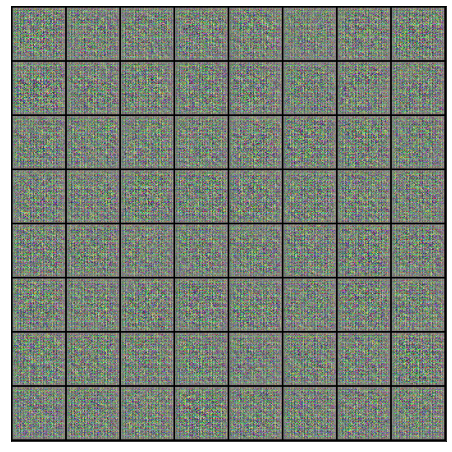

In [231]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [232]:
generator = to_device(generator, device)

In [233]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [234]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [235]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [236]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [237]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


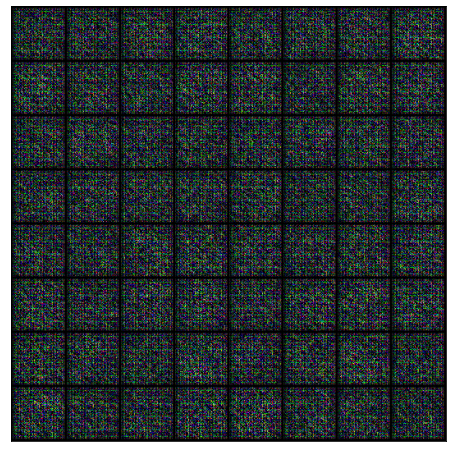

In [238]:
save_samples(0, fixed_latent)

In [239]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.60, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.60, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [240]:
lr = 0.0004
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/100], loss_g: 5.0757, loss_d: 0.2304, real_score: 0.9677, fake_score: 0.1438
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.0520, loss_d: 0.4713, real_score: 0.8508, fake_score: 0.2036
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 5.0416, loss_d: 0.7767, real_score: 0.8340, fake_score: 0.3544
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.0970, loss_d: 0.1821, real_score: 0.9353, fake_score: 0.0865
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.3738, loss_d: 0.3959, real_score: 0.8544, fake_score: 0.1746
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 2.2901, loss_d: 0.4256, real_score: 0.7419, fake_score: 0.0810
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 0.0149, loss_d: 1.5717, real_score: 0.3430, fake_score: 0.1092
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 3.4366, loss_d: 0.6059, real_score: 0.7338, fake_score: 0.1030
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 2.8060, loss_d: 0.5802, real_score: 0.7283, fake_score: 0.1841
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.1578, loss_d: 0.2194, real_score: 0.9489, fake_score: 0.1241
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.3122, loss_d: 0.4571, real_score: 0.8094, fake_score: 0.1497
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.9453, loss_d: 0.7942, real_score: 0.5991, fake_score: 0.1158
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.9483, loss_d: 0.1613, real_score: 0.8852, fake_score: 0.0316
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.4600, loss_d: 0.3310, real_score: 0.7765, fake_score: 0.0336
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 0.3318, loss_d: 1.7482, real_score: 0.3908, fake_score: 0.0990
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.7195, loss_d: 1.3573, real_score: 0.4622, fake_score: 0.1244
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.5733, loss_d: 0.2288, real_score: 0.9429, fake_score: 0.1226
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.0612, loss_d: 0.4803, real_score: 0.7873, fake_score: 0.1630
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.3468, loss_d: 0.4131, real_score: 0.7497, fake_score: 0.0800
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.9724, loss_d: 0.6006, real_score: 0.6645, fake_score: 0.1318
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.3022, loss_d: 0.8061, real_score: 0.4883, fake_score: 0.0633
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.2659, loss_d: 1.2209, real_score: 0.6290, fake_score: 0.0925
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.0134, loss_d: 2.6002, real_score: 0.1405, fake_score: 0.0900
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 0.1733, loss_d: 3.4782, real_score: 0.0922, fake_score: 0.1954
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.7161, loss_d: 0.3490, real_score: 0.8040, fake_score: 0.0649
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.5333, loss_d: 0.2080, real_score: 0.9031, fake_score: 0.0857
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 1.2859, loss_d: 0.7520, real_score: 0.6101, fake_score: 0.0496
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.5649, loss_d: 0.7329, real_score: 0.6225, fake_score: 0.1013
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.7667, loss_d: 0.2750, real_score: 0.9223, fake_score: 0.1456
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.1042, loss_d: 0.3915, real_score: 0.8028, fake_score: 0.1326
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.1930, loss_d: 0.4819, real_score: 0.7895, fake_score: 0.1527
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.6437, loss_d: 0.3129, real_score: 0.8803, fake_score: 0.1386
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 0.2718, loss_d: 2.3270, real_score: 0.4013, fake_score: 0.1420
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.8412, loss_d: 0.2518, real_score: 0.9102, fake_score: 0.1248
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.8947, loss_d: 0.2370, real_score: 0.9339, fake_score: 0.1287
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.8218, loss_d: 0.4065, real_score: 0.8712, fake_score: 0.1737
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 0.1283, loss_d: 1.7103, real_score: 0.3769, fake_score: 0.0971
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 1.5882, loss_d: 0.6458, real_score: 0.7185, fake_score: 0.1047
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.2921, loss_d: 2.3043, real_score: 0.2889, fake_score: 0.0565
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 0.0071, loss_d: 2.7621, real_score: 0.1372, fake_score: 0.1030
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.2137, loss_d: 0.2689, real_score: 0.8503, fake_score: 0.0820
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.7229, loss_d: 0.8620, real_score: 0.5927, fake_score: 0.0688
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.6675, loss_d: 0.3127, real_score: 0.7903, fake_score: 0.0566
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.1124, loss_d: 0.1406, real_score: 0.9653, fake_score: 0.0879
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.4767, loss_d: 0.5353, real_score: 0.8655, fake_score: 0.2498
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 5.4076, loss_d: 0.2081, real_score: 0.9401, fake_score: 0.1115
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.4510, loss_d: 0.6871, real_score: 0.7128, fake_score: 0.1236
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.3183, loss_d: 0.7008, real_score: 0.5887, fake_score: 0.0299
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.3131, loss_d: 0.2584, real_score: 0.9959, fake_score: 0.1856
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.3567, loss_d: 0.9393, real_score: 0.4861, fake_score: 0.1200
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.2697, loss_d: 0.5412, real_score: 0.6262, fake_score: 0.0232
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.1245, loss_d: 0.8296, real_score: 0.6110, fake_score: 0.0840
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 1.5421, loss_d: 0.5836, real_score: 0.6907, fake_score: 0.0610
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 0.7139, loss_d: 0.9078, real_score: 0.6539, fake_score: 0.1077
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.9810, loss_d: 0.1471, real_score: 0.9823, fake_score: 0.1081
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.0260, loss_d: 0.1751, real_score: 0.9596, fake_score: 0.1067
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.0502, loss_d: 0.3208, real_score: 0.8162, fake_score: 0.0941
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.8869, loss_d: 0.1429, real_score: 0.9272, fake_score: 0.0541
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 0.6479, loss_d: 0.5334, real_score: 0.6887, fake_score: 0.0476
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 0.8956, loss_d: 0.8427, real_score: 0.5672, fake_score: 0.0505
Saving generated-images-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.2408, loss_d: 0.0682, real_score: 0.9883, fake_score: 0.0523
Saving generated-images-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 0.0231, loss_d: 1.5660, real_score: 0.2814, fake_score: 0.0641
Saving generated-images-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 5.3696, loss_d: 0.0956, real_score: 0.9968, fake_score: 0.0775
Saving generated-images-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.2479, loss_d: 1.2758, real_score: 0.6481, fake_score: 0.1555
Saving generated-images-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.7940, loss_d: 1.0990, real_score: 0.5551, fake_score: 0.0492
Saving generated-images-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.1008, loss_d: 0.1925, real_score: 0.9659, fake_score: 0.1248
Saving generated-images-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 0.4136, loss_d: 1.3070, real_score: 0.3760, fake_score: 0.0942
Saving generated-images-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.2140, loss_d: 0.3992, real_score: 0.9042, fake_score: 0.2131
Saving generated-images-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 0.1788, loss_d: 1.5160, real_score: 0.3402, fake_score: 0.1141
Saving generated-images-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 0.8842, loss_d: 0.6579, real_score: 0.6259, fake_score: 0.1044
Saving generated-images-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.5618, loss_d: 0.3479, real_score: 0.8225, fake_score: 0.1122
Saving generated-images-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 0.2402, loss_d: 3.3829, real_score: 0.2143, fake_score: 0.0733
Saving generated-images-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 1.4964, loss_d: 0.5862, real_score: 0.6825, fake_score: 0.1077
Saving generated-images-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 0.0470, loss_d: 1.3715, real_score: 0.3757, fake_score: 0.1182
Saving generated-images-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 0.1621, loss_d: 2.2652, real_score: 0.1181, fake_score: 0.0559
Saving generated-images-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 0.7021, loss_d: 0.6611, real_score: 0.6333, fake_score: 0.1196
Saving generated-images-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 2.1255, loss_d: 0.6980, real_score: 0.7216, fake_score: 0.0761
Saving generated-images-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 1.8480, loss_d: 0.2813, real_score: 0.8696, fake_score: 0.1097
Saving generated-images-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.6763, loss_d: 0.2514, real_score: 0.8873, fake_score: 0.1034
Saving generated-images-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.9983, loss_d: 0.6756, real_score: 0.6473, fake_score: 0.1458
Saving generated-images-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 0.6073, loss_d: 0.5305, real_score: 0.7036, fake_score: 0.1135
Saving generated-images-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 0.3299, loss_d: 2.0019, real_score: 0.2695, fake_score: 0.1383
Saving generated-images-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.0674, loss_d: 0.2349, real_score: 0.9147, fake_score: 0.1126
Saving generated-images-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.3952, loss_d: 0.4062, real_score: 0.7069, fake_score: 0.0332
Saving generated-images-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.2105, loss_d: 0.2713, real_score: 0.9699, fake_score: 0.1705
Saving generated-images-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.0799, loss_d: 0.1647, real_score: 0.9088, fake_score: 0.0603
Saving generated-images-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 0.2289, loss_d: 0.6175, real_score: 0.6189, fake_score: 0.1017
Saving generated-images-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.9539, loss_d: 0.2534, real_score: 0.9225, fake_score: 0.1276
Saving generated-images-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.1110, loss_d: 0.2236, real_score: 0.9325, fake_score: 0.1193
Saving generated-images-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.2210, loss_d: 1.5522, real_score: 0.3002, fake_score: 0.0346
Saving generated-images-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 0.1644, loss_d: 1.7626, real_score: 0.3841, fake_score: 0.1184
Saving generated-images-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.7427, loss_d: 0.1824, real_score: 0.9912, fake_score: 0.1393
Saving generated-images-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.3672, loss_d: 0.1719, real_score: 0.9306, fake_score: 0.0746
Saving generated-images-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 0.1848, loss_d: 3.2221, real_score: 0.1248, fake_score: 0.1885
Saving generated-images-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 0.1063, loss_d: 2.1530, real_score: 0.2921, fake_score: 0.1304
Saving generated-images-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 1.8469, loss_d: 0.4996, real_score: 0.6889, fake_score: 0.0692
Saving generated-images-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 0.1152, loss_d: 2.2588, real_score: 0.1862, fake_score: 0.0634
Saving generated-images-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

In [242]:
losses_g, losses_d, real_scores, fake_scores = history

In [243]:
from IPython.display import Image

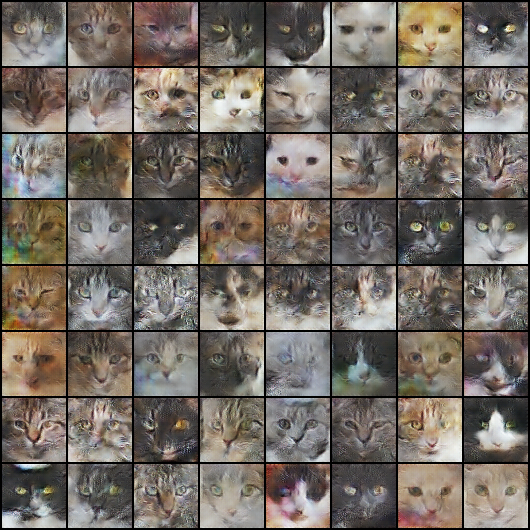

In [244]:
Image('./generated/generated-images-0100.png')

In [245]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

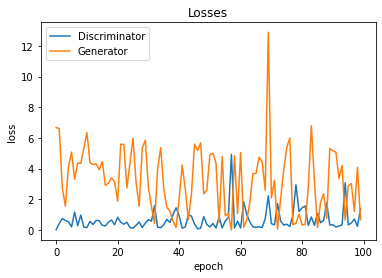

In [246]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

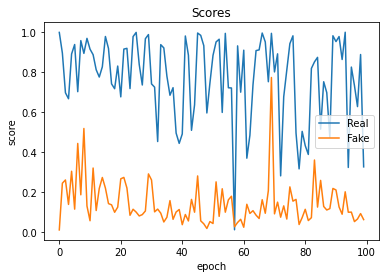

In [247]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');